In [2]:
#########################
# Functions and Imports
#########################

#run this first

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.special import jv
from PIL import Image
import cv2
from scipy.ndimage import binary_fill_holes
import time
from scipy.linalg import solve_sylvester

def get_square_H(s,skin_depth,resolution,H0=1):
    k = (1-1j)/skin_depth
    dx = s/resolution #stepsize: x direction
    beta_x = 1/dx**2 #avoid repeated operations
    alpha_x = -2*beta_x+k**2/2
    Xmat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize data matrix
    # Ymat = np.zeros([resolution,resolution],dtype=np.complex_) #Initialize B matrix
    # corners
    Xmat[0][0] = alpha_x
    Xmat[resolution-1][resolution-1] = alpha_x

    #interior
    for i in range(1,resolution-1):
        Xmat[i][i]= alpha_x #alpha_x

        Xmat[i][i+1]= beta_x #beta_x
        Xmat[i][i-1]= beta_x #beta_x
        #this set the points to the right and left of the diagonal

    #remaining two exterior points
    Xmat[0][1] = beta_x
    Xmat[resolution-1][resolution-2] = beta_x

    C = np.zeros([resolution,resolution],dtype=np.complex_) #boundary conditions (The 
    #component of H parallel to the surface of the conductor is continuous 
    #provided there are no free surface currents.) 

    H_beta_x = -H0*beta_x

    C[0][0] = 2*H_beta_x
    C[resolution-1][0] = 2*H_beta_x
    C[0][resolution-1] = 2*H_beta_x
    C[resolution-1][resolution-1] = 2*H_beta_x

    for i in range(1,resolution-1):
        C[0][i] = H_beta_x
        C[resolution-1][i] = H_beta_x
        C[i][0] = H_beta_x
        C[i][resolution-1] = H_beta_x
        
    X = solve_sylvester(Xmat,Xmat,C)
    
    for i in range(resolution):
        for j in range(resolution):
            if X[i][j].real > 1:
                print("Error at position ",i,", ",j) #It is unphysical for the 
                #field to be larger in magnitude within the conductor than outside of it 
                #(provided that it is not magnetic).
    # print(X-solve_sylvester(Xmat,Xmat,C))             
    NewX= np.zeros([resolution+2,resolution+2],dtype=np.complex_) 
    for i in range(resolution+2): #This for loop defines the field at the surface 
        #of the conductor (It must be H0).
        
        for j in range(resolution+2):
            if ((i ==0) or (i==(resolution+1)) or (j ==0) or (j==(resolution+1))):
                NewX[i][j] =H0 
            else:
                NewX[i][j]=X[i-1][j-1]
    return NewX

def get_cylind_H(d,skin_depth,resolution):
    k = (1-1j)/skin_depth
    cylindH = np.ones([resolution+2,resolution+2],dtype=np.complex_)
    demon = 1/jv(0,d/2*k)
    for i in range(1,resolution+1):
        for j in range(1,resolution+1):
            if ((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)*4<=resolution**2:
                cylindH[i][j] = jv(0,np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)*d/(resolution)*k)*demon
    return cylindH

def get_shape_H(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    dx = s/(resolution +1)  # grid spacing

    # Define the initial condition
    # z = np.ones((resolution, resolution), dtype=np.complex128)  # initial solution matrix
    # shape_inds = np.array([])
    # for i in range(1, resolution - 1):  # loop over the interior points in x
    #     for j in range(1, resolution - 1):  # loop over the interior points in y
    #         if mask[i, j] == 1:
    #             r = np.sqrt((i-(resolution+1)/2)**2 + (j-(resolution+1)/2)**2)/(resolution+1)*s
    #             z[i,j] = jv(0,r*k)/jv(0,s/2*k)
    #             # shape_inds = np.append(shape_inds,(i,j))

    z = better_guess(mask,s,skin_depth)

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # for n in range(iterations):
    #     old_z = z.copy()
    #     for i in range(1, resolution - 1):  # loop over the interior points in x
    #         for j in range(1, resolution - 1):  # loop over the interior points in y
    #             if mask[i, j] == 1:  # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (old_z[i+1, j] + old_z[i-1, j] + old_z[i, j+1] + old_z[i, j-1]) * inv_denom

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] += ((z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom - z[i, j])

    # Time to iterate_new ...slower??
    # inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations
    # inx = np.transpose(np.where(mask == 0))
    # print(inx)
    # for n in range(iterations):
    #     for i,j in inx: # loop over the interior points in   
    #                 # check if the current point is in the interior
    #                 #update the current point using the finite difference method
    #                 z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
    return z

def get_shape_H_Show_Phase(mask,s,skin_depth,iterations):
    k_squared = -2j / (skin_depth)**2 
    resolution = len(mask)
    dx = s/(resolution + 1)  # grid spacing
    phases = np.zeros(iterations)

    z = better_guess(mask,s,skin_depth)

    # Time to iterate
    inv_denom = 1/(4 - k_squared * dx**2) #limit repeated calculations

    for n in range(iterations): #oldest model of iterations
        for i in range(1, resolution - 1):  # loop over the interior points in x
            for j in range(1, resolution - 1):  # loop over the interior points in y
                if mask[i, j] == 1:  # check if the current point is in the interior
                    #update the current point using the finite difference method
                    z[i, j] = (z[i+1, j] + z[i-1, j] + z[i, j+1] + z[i, j-1]) * inv_denom
        phases[n] = np.angle(double_Integral(z,s)/s**2-1)
    i1 = np.logical_not(phases<0)
    phases[i1]-= 2*np.pi

    fig = plt.figure(constrained_layout = True, figsize=(4.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(np.arange(iterations),phases)
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel('Phase (rad)')
    ax.set_title('Phase behavior')
    plt.show()
    return z

def get_skin_depth(rho,frequency=671111):
    return (2*rho/(4e-7*np.pi*2 * np.pi *frequency))**.5

def get_rgb_lists(image_path):
    with Image.open(image_path) as im:
        full_rgbs =  np.array(im)
    ylen = len(full_rgbs)
    xlen = len(full_rgbs[0])
    r = np.zeros([ylen,xlen])
    g = np.zeros([ylen,xlen])
    b = np.zeros([ylen,xlen])
    for y in range(ylen):
        for x in range(xlen):
            r[y][x] = full_rgbs[y][x][0]
            g[y][x] = full_rgbs[y][x][1]
            b[y][x] = full_rgbs[y][x][2]
    return r,g,b

def get_mask(image_path, cutoff1 = 150, cutoff2 = 150, kernal_size=55,line_size=5):
    bs = get_rgb_lists(image_path)[2]
    intial_blur = cv2.blur(bs,(kernal_size,kernal_size)) #this takes the average of kernal_size by kernal_size region centered at each point
    made_cut = np.zeros([len(bs),len(bs[0])])
    first_cut = intial_blur.max()-intial_blur #this makes the dark spots highest amplitude
    # print(len(bs),len(bs[0]))
    for i in range(len(bs)):
        for j in range(len(bs[0])):
            if first_cut[i][j] < cutoff1:
                first_cut[i][j] = 0
            else:
                first_cut[i][j] -= cutoff1
                made_cut[i][j] = 255

    second_cut = cv2.blur(made_cut, (kernal_size, kernal_size))
    for i in range(len(bs)):
        for j in range(len(bs[0])):
            if second_cut[i][j] > cutoff2:
                second_cut[i][j] = 1
            else:
                second_cut[i][j] = 0
    second_cut_trans = np.transpose(second_cut)
    
    #find bounds of sample
    for i in range(len(bs)):
        if second_cut[i].sum()!=0:
            x1 = i
            break
    for j in range(len(bs)-1,-1,-1):
        if second_cut[j].sum()!=0:
            x2 = j
            break
    for i in range(len(bs[0])):
        if second_cut_trans[i].sum()!=0:
            y1 = i
            break
    for j in range(len(bs[0])-1,-1,-1):
        if second_cut_trans[j].sum()!=0:
            y2 = j
            break
    final_cut = binary_fill_holes(second_cut) #fill any holes

    edge_finder = cv2.blur(abs(cv2.Laplacian(second_cut,cv2.CV_64F)),(line_size,line_size))
    cutoff3 = edge_finder.max()/8
    for i in range(len(bs)):
        for j in range(len(bs[0])):
            if edge_finder[i][j] >cutoff3:
                edge_finder[i][j]=1
            else:
                edge_finder[i][j]=0
    overlayed = cv2.imread(image_path)
    for i in range(len(bs)):
        for j in range(len(bs[0])):
            if edge_finder[i][j]:
                overlayed[i][j] = (0, 0, 255)#red

    fig = plt.figure(constrained_layout = True)
    ax = fig.add_subplot(1, 2, 1)
    bx = fig.add_subplot(1, 2, 2)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    p1 = ax.imshow(first_cut)
    ax.set_title('After First Cut')
    fig.colorbar(p1, ax=ax)
    bx.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
    bx.set_title('Shape Overlayed onto Original Photo')
    plt.show()

    
    #return appriate square shape
    #this could break if the sample is too close to one of the edges and is a lot longer in one dimension, but thats fine. Avoid that. Good cropping
    diff = x2-x1-(y2-y1)
    # print(diff)
    if diff>0:#delta x is bigger than delta y
        if diff %2 == 0:
            # differenece between each index should be x2-x1 +3 or y2-y1 +3 (whichever is larger)
            return final_cut[x1-1:x2+2,y1-diff//2-1:y2+diff//2+2]
        else:
            return final_cut[x1-1:x2+2,y1-(diff-1)//2-1:y2+(diff+1)//2+1]
    else:#delta y is bigger than delta x
        if diff %2 == 0:
            return final_cut[x1+diff//2-1:x2-diff//2+2,y1-1:y2+2]#
        else:
            return final_cut[x1+(diff+1)//2-1:x2-(diff-1)//2+2,y1-1:y2+2]

def get_dx(image_path,pixel_num,top, bot, lef, rig):
    with Image.open(image_path) as im:
        full_rgbs =  np.array(im)
    ylen = len(full_rgbs)
    xlen = len(full_rgbs[0])
    r = np.zeros([ylen,xlen])
    g = np.zeros([ylen,xlen])
    b = np.zeros([ylen,xlen])
    for y in range(ylen):
        for x in range(xlen):
            r[y][x] = full_rgbs[y][x][0]
            g[y][x] = full_rgbs[y][x][1]
            b[y][x] = full_rgbs[y][x][2]

    boxes = .5e-3 # known mm /box

    # not_blue = (r+b)/2 #Now i am using cyan
    lefts = np.transpose(r)[0+lef]
    rights = np.transpose(r)[-1-rig]
    tops = r[0+top]
    bottoms = r[-1-bot]

    top_amplitudes = fft(tops)
    bottom_amplitudes = fft(bottoms)
    left_amplitudes = fft(lefts)
    right_amplitudes = fft(rights)

    x_freqs = fftfreq(xlen, 1)[:xlen//2]# get the frequencies that coorespond to the amplitudes calculated in the previous line
    y_freqs = fftfreq(ylen, 1)[:xlen//2]# get the frequencies that coorespond to the amplitudes calculated in the previous line
    top_line_spacing = x_freqs[np.argmax(np.absolute(top_amplitudes)[1:xlen//2])+1]# this is the boxes per pixel
    bottom_line_spacing = x_freqs[np.argmax(np.absolute(bottom_amplitudes)[1:xlen//2])+1]
    left_line_spacing = y_freqs[np.argmax(np.absolute(left_amplitudes)[1:xlen//2])+1]
    right_line_spacing = y_freqs[np.argmax(np.absolute(right_amplitudes)[1:xlen//2])+1]

    dxs =[top_line_spacing,bottom_line_spacing,right_line_spacing,left_line_spacing] # this are the boxes per pixel
    
    fig = plt.figure(constrained_layout = True)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(tops)
    ax.plot(bottoms)
    ax.plot(lefts)
    ax.plot(rights)
    ax.set_title('Grid Fourier Analysis')
    ax.set_xlabel('Pixels')
    ax.set_ylabel('Red Intensity out of 255')
    ax.legend(['top','bottom','left','right'])
    plt.show()
    print('top: {} mm\nbottom: {} mm\nright: {} mm\nleft: {} mm'.format(top_line_spacing*pixel_num*.5,bottom_line_spacing*pixel_num*.5,right_line_spacing*pixel_num*.5,left_line_spacing*pixel_num*.5))
    return boxes * np.average(dxs) *pixel_num #returns the average matrix side length in meters

def double_Integral(data, d):
    #https://stackoverflow.com/questions/20668689/integrating-2d-samples-on-a-rectangular-grid-using-scipy
    n = len(data)#assumes square 2d array that has physical length of d by d meters
    dA = ((d-0)/(n-1)) * ((d-0)/(n-1))

    data_Internal = data[1:-1, 1:-1]

    # sides: up, down, left, right
    (data_u, data_d, data_l, data_r) = (data[0, 1:-1], data[-1, 1:-1], data[1:-1, 0], data[1:-1, -1])

    # corners
    (data_ul, data_ur, data_dl, data_dr) = (data[0, 0], data[0, -1], data[-1, 0], data[-1, -1])

    return dA * (np.sum(data_Internal)\
                + 0.5 * (np.sum(data_u) + np.sum(data_d) + np.sum(data_l) + np.sum(data_r))\
                + 0.25 * (data_ul + data_ur + data_dl + data_dr))

def change_mask_size(old_mask,new_size):
    if new_size != len(old_mask):
        new_mask = np.zeros([new_size,new_size],dtype=np.int64)
        rows = np.zeros([len(old_mask),new_size],dtype=np.float64)
        cols = np.zeros([len(old_mask),new_size],dtype=np.float64)
        for i, row in enumerate(old_mask):
            rows[i] = np.interp(np.linspace(0,1,new_size),np.linspace(0,1,len(old_mask)),row)
        for i, col in enumerate(np.transpose(old_mask)):
            cols[i] = np.interp(np.linspace(0,1,new_size),np.linspace(0,1,len(old_mask)),col)

        final_rows = np.zeros([new_size,new_size],dtype=np.float64)
        final_cols = np.zeros([new_size,new_size],dtype=np.float64)

        
        if new_size < len(old_mask):
            for i in range(new_size): #i is the index of the row for the final rows
                for j in range(new_size): #j is the index of the col for the final rows
                    summ = 0
                    count = 0
                    for k, row in enumerate(rows):#k is the index that scrolls through the too long part of rows and averages the values to the right size
                        if k*new_size//len(rows) == j:
                            summ +=rows[k][i]
                            count +=1
                    final_rows[j][i] = summ/count
            
            for i in range(new_size): #i is the index of the row for the final rows
                for j in range(new_size): #j is the index of the col for the final rows
                    summ = 0
                    count = 0
                    for k, row in enumerate(cols):#k is the index that scrolls through the too long part of rows and averages the values to the right size
                        if k*new_size//len(cols) == j:
                            summ +=cols[k][i]
                            count +=1
                    final_cols[j][i] = summ/count


        if new_size > len(old_mask):
            for i in range(new_size): #i is the index of the row for the final rows
                for j in range(new_size): #j is the index of the col for the final rows
                    final_rows[j][i] = rows[j*new_size//len(rows)][i]
            
            for i in range(new_size): #i is the index of the row for the final rows
                for j in range(new_size): #j is the index of the col for the final rows
                    final_cols[j][i] = rows[j*new_size//len(cols)][i]


        return np.rint((final_rows+np.transpose(final_cols))*.5)
    return old_mask

def get_outline(mask,line_size,img):
    edge_finder = cv2.blur(abs(cv2.Laplacian(mask,cv2.CV_64F)),(line_size,line_size))
    cutoff3 = edge_finder.max()/8
    for i in range(len(mask)):
        for j in range(len(mask)):
            if edge_finder[i][j] >cutoff3:
                edge_finder[i][j]=1
            else:
                edge_finder[i][j]=0
    # edge_finder = np.where(edge_finder > cutoff3,1,0)
    overlayed = img.copy()
    for i in range(len(mask)):
        for j in range(len(mask)):
            if edge_finder[i][j]:
                overlayed[i][j] = (0, 0, 255)#red
    return overlayed 
    #TODO complete this funciton: it is not totally working. I have to center the outline on the sample image somehow

def get_area(mask,s):
    count = 0
    for i in range(len(mask)):
        for j in range(len(mask[0])):
            if mask[i][j]:
                count += 1
    return s**2*count/(len(mask)*len(mask[0])) #this gives area in units of s**2

def get_nearest_edge(mask,s):
    radii = np.zeros([len(mask),len(mask[0])],dtype=np.float64)
    for i in range(1, len(mask) - 1):  # loop over the interior points in x
        for j in range(1, len(mask[0]) - 1):  # loop over the interior points in y
            reach = 1
            if mask[i, j]:
                r = np.Infinity# r is defined to be the distance between centers of pixels in units of a single pixel length
                while reach < r:
                    if (not(mask[i+reach,j]) or not(mask[i-reach,j]) or not(mask[i,j+reach]) or not(mask[i,j+reach])) and r>reach:#check edge centers if odd
                            r = reach
                            break #if this ever happens, it is always the shortest path because every next point is farther away
                    for edge in range(1,reach): #then check two sqaures on either edge of edge center (eight total places to check for each distance)
                        if (not(mask[i+reach,j+edge]) or not(mask[i+reach,j-edge]) or 
                            not(mask[i-reach,j+edge]) or not(mask[i-reach,j-edge]) or 
                            not(mask[i+edge,j+reach]) or not(mask[i-edge,j+reach]) or
                            not(mask[i+edge,j+reach]) or not(mask[i-edge,j+reach])) and r**2>reach**2+edge**2:#check edge centers if odd
                            r = np.sqrt(reach**2+edge**2)
                            break # this breaks of because each next edge is farther
                    if (not(mask[i+reach,j+reach]) or not(mask[i-reach,j+reach]) or not(mask[i+reach,j-reach]) or not(mask[i-reach,j-reach])) and r>reach*2**.5:#check edge centers if odd
                            r = reach*2**.5 #check corners
                    reach += 1 #move out a layer
                radii[i,j] = r*s/len(mask)
    return radii

def better_guess(mask,s,skin_depth):
    a = np.sqrt(get_area(mask,s)/np.pi) #this is the radius of the circle with the same area of the mask
    rs = get_nearest_edge(mask,s)
    k = (1 - 1j) / skin_depth
    resolution = len(mask)
    good_guess = np.ones((resolution, resolution), dtype=np.complex128)
    i = np.logical_not(mask == 0)
    good_guess[i] = jv(0,(a-rs[i])*k)/jv(0,a*k)
    return good_guess

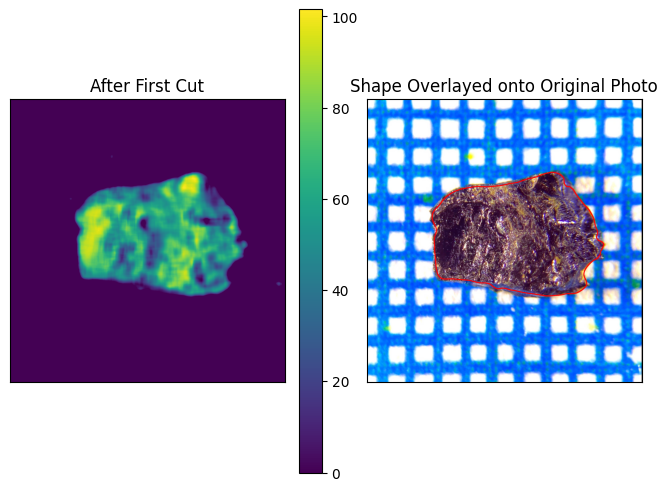

In [10]:
#Image Processing

# image_path = "C:/Users/blake/Downloads/Sampletestpic.jpg"
# image_path = 'C:/Users/blake/Documents/VSCode/Python/Greven/2023_4_6.jpg'
image_path = "C:/Users/blake/Downloads/BW79_1.jpg"

#all the cutoffs have a range of 1 to 255. Good starting range is between 125 and 175 for both
cutoff1 = 110 #lower values will include more, but have more shadows
cutoff2 = 150 #this fills holes and smooths
kernal_size = 75 #must be odd, bigger will be less precise, but get rid of random noise, dots, etc
line_size = 9 #this must be an odd integer. It is the thickness of the edge lines (purely astetic)

raw_mask = get_mask(image_path, cutoff1, cutoff2, kernal_size, line_size) #this gets a binary valued n by n matrix that encodes the shape of the sample from the sample picture

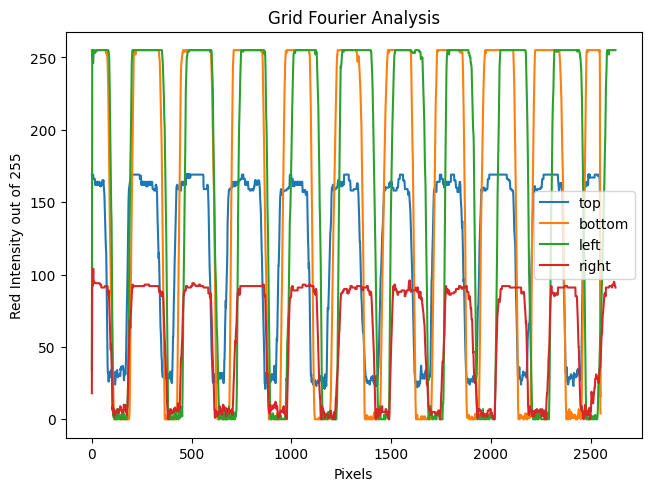

top: 3.119607843137255 mm
bottom: 3.119607843137255 mm
right: 3.0304761904761905 mm
left: 3.0304761904761905 mm
longest sample direction =  3.075042016806723 mm


In [13]:
# Fourier to get sample length

top_bump = 1 # keep these zero unless noise is seen in Fourier plot, then bump until clear
bottom_bump = 0 # Each bump must be a non-negative integer
left_bump = 0
right_bump = 2

s = get_dx(image_path,len(raw_mask),top_bump, bottom_bump, left_bump, right_bump) #this gets the distance in meters of the longest dimenion of the sample. This can be thought of as the side length of the 
print('longest sample direction = ',s*1e3,'mm')

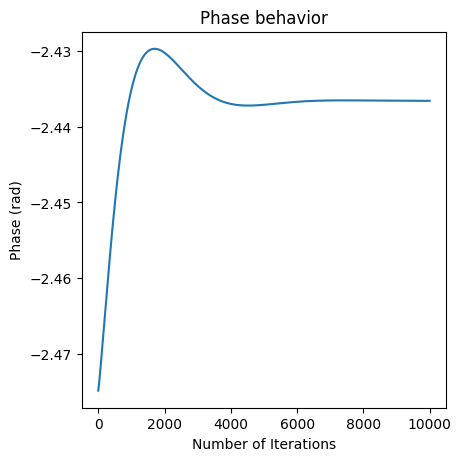

132.21104669570923


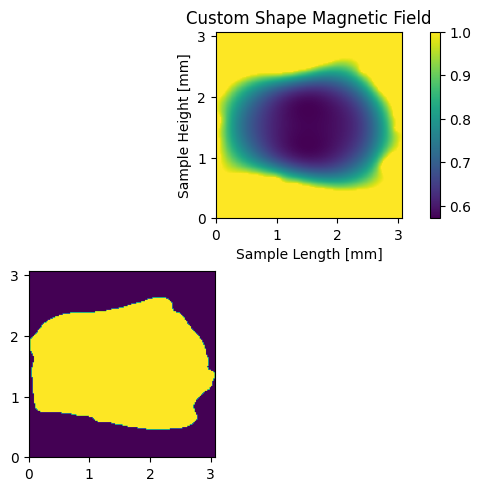

In [16]:
#FEA Test for phase convergence

repeats = 10000
mask_size = 150

mask = change_mask_size(raw_mask, mask_size)

t1 = time.time()
sample_H = get_shape_H_Show_Phase(mask,s,get_skin_depth(1e-6),repeats) #this is the FEA function. This gets the magnetic field across the mask's geometry
t2 = time.time()
print(t2 - t1)

# plot magnetic field
fig1 = plt.figure(constrained_layout = True)
ax = fig1.add_subplot(2, 1, 1)
bx = fig1.add_subplot(2, 1, 2)
p1 = ax.imshow(np.absolute(sample_H),extent=[0, s*1e3, 0, s*1e3])#,norm=colors.LogNorm(vmin=np.absolute(sample_H).min(), vmax=1))#,norm=colors.LogNorm(vmin=min(np.absolute(sample_H )), vmax=1))
fig1.colorbar(p1, ax=ax)
ax.set_xlabel('Sample Length [mm]')
ax.set_ylabel('Sample Height [mm]')
ax.set_title('Custom Shape Magnetic Field')
#plot mask for comparision
_ = bx.imshow(np.absolute(mask),extent=[0, s*1e3, 0, s*1e3])

Time estimate:  3.6725290748808117 hr,  220.35174449284872 min
Sample Effect Radius is  1.2750457703530294 mm


Text(0.5, 1.0, 'Custom Shape Magnetic Field')

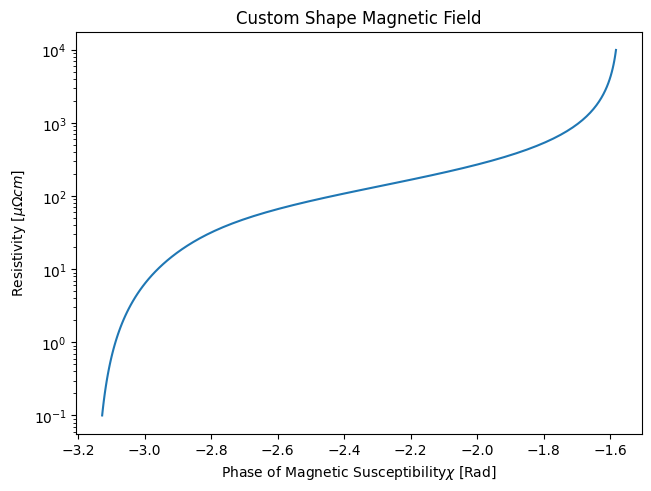

In [17]:
##############################################
# Resistivity v Magnetic Susecptibility Phase
##############################################

rhos = np.logspace(-9,-4,100)
print('Time estimate: ', len(rhos)*(t2-t1)/3600, 'hr, ',len(rhos)*(t2-t1)/60, 'min')
sample_chis = np.zeros(len(rhos),dtype=np.complex_) #Stores the effective magnetic susceptibility for the sample
cy_chis = np.zeros(len(rhos),dtype=np.complex_) #analytical solution for cylinder
a = np.sqrt(get_area(raw_mask,s)/np.pi)
print('Sample Effect Radius is ',a*1e3,'mm')

for i, rho in enumerate(rhos):
    sample_H = get_shape_H(mask,s,get_skin_depth(rho),repeats) #get magnetic field
    sample_chis[i] = double_Integral(sample_H,s)/s**2-1 #get effective magnetic susceptibility from magnetic field
    delta = get_skin_depth(rho)
    k =(1-1j)/delta
    cy_chis[i] = 2/a/k*jv(1,a*k)/jv(0,a*k)-1

fig2 = plt.figure(constrained_layout = True)
cx = fig2.add_subplot(1, 1, 1)
cx.plot(np.angle(sample_chis),rhos*1e8)#-np.pi)
cx.set_ylabel(r'Resistivity [$\mu \Omega cm$]')
cx.set_xlabel(r'Phase of Magnetic Susceptibility$\chi$ [Rad]')
cx.set_yscale('log')
cx.set_title('Custom Shape Magnetic Field')

In [8]:
# chis_sq = np.zeros(len(rhos),dtype=np.complex_) #square
# s = 1e-3 # length in meters
# d = 2e-3/np.pi**.5 #diameter in meters
# a=d/2 #radius

# resolution = 150
# for i, rho in enumerate(rhos):
#     Square = get_square_H(s,get_skin_depth(rho),resolution)
#     chis_sq[i] = double_Integral(Square,s)/s**2-1

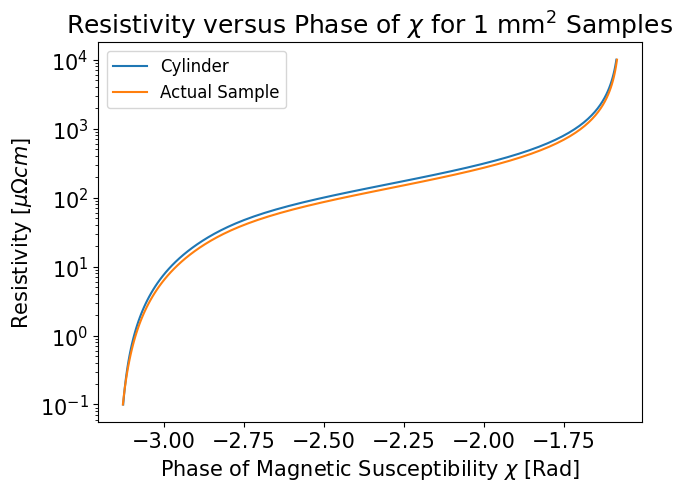

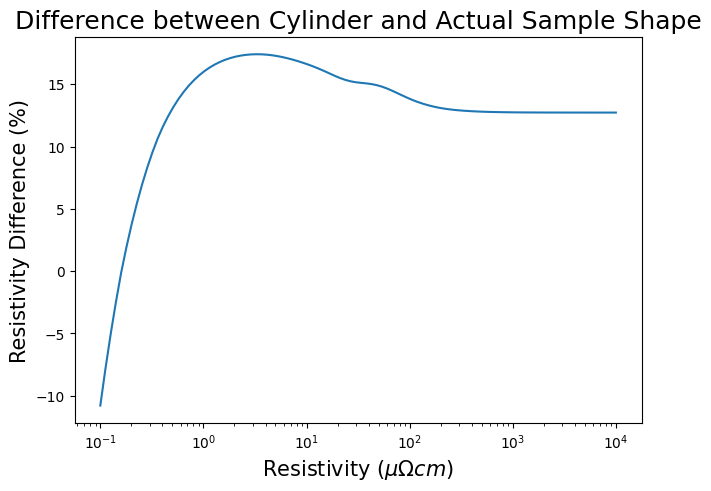

In [24]:

fig = plt.figure(constrained_layout = True)
cx = fig.add_subplot(1, 1, 1)
cx.plot(np.angle(cy_chis),rhos*1e8)
# cx.plot(np.angle(chis_sq),rhos*1e8)
cx.plot(np.angle(sample_chis),rhos*1e8)
cx.set_yscale('log')
cx.set_ylabel(r'Resistivity [$\mu \Omega cm$]',fontsize = 15)
cx.set_xlabel(r'Phase of Magnetic Susceptibility $\chi$ [Rad]',fontsize = 15)
cx.set_title(r'Resistivity versus Phase of $\chi$ for 1 mm$^2$ Samples',fontsize = 18)
# cx.legend(['Cylinder','Square','Actual Sample'], fontsize=12)
cx.legend(['Cylinder','Actual Sample'], fontsize=12)
cx.tick_params(axis='x', labelsize=15)
cx.tick_params(axis='y', labelsize=15)

fig3 = plt.figure(constrained_layout = True)
ax = fig3.add_subplot(1, 1, 1)
# ax.plot(rhos*1e8,np.angle(cy_chis)-np.angle(sample_chis))
ax.plot(rhos*1e8,(rhos*1e8-np.interp(np.angle(cy_chis),np.angle(sample_chis),rhos*1e8))/rhos*1e-6)
ax.set_xscale('log')
ax.set_xlabel(r'Resistivity ($\mu \Omega cm$)',fontsize = 15)
ax.set_ylabel(r'Resistivity Difference (%)',fontsize = 15)
# ax.set_ylabel(r'Phase of Magnetic Susceptibility $\chi$ [Rad]',fontsize = 15)
ax.set_title(r'Difference between Cylinder and Actual Sample Shape',fontsize = 18)
cx.tick_params(axis='x', labelsize=15)
cx.tick_params(axis='y', labelsize=15)